# 빅데이터분석개론 기말고사 1번
### 컴퓨터공학과 201835641 김지훈

# 1. 네이버 API를 사용한 크롤링

## 1. 필요한 라이브러리 import

In [68]:
import urllib.request
import datetime

### 1.1.1. 네이버에서 발급 받은 id랑 key 정보 

In [69]:
client_id = '6SB8l3GhOnPlLD4GZiWT'
client_secret = '21pG4I6sih'

## 1.2.1. 원하는 단어 크롤링

In [70]:
def getRequestUrl(url):    
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_secret)
    
    try: 
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print ("[%s] Url Request Success" % datetime.datetime.now())
            return response.read().decode('utf-8')
    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None


In [71]:
def getNaverSearch(node, srcText, start, display):    
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(srcText), start, display)
    
    url = base + node + parameters    
    responseDecode = getRequestUrl(url)   #[CODE 1]
    
    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

In [72]:
def getPostData(post, jsonResult, cnt):    
    title = post['title']
    description = post['description']
    org_link = post['originallink']
    link = post['link']
    
    pDate = datetime.datetime.strptime(post['pubDate'],  '%a, %d %b %Y %H:%M:%S +0900')
    pDate = pDate.strftime('%Y-%m-%d %H:%M:%S')
    
    jsonResult.append({'cnt':cnt, 'title':title, 'description': description, 
'org_link':org_link,   'link': org_link,   'pDate':pDate})
    return    

In [73]:
def main():
    node = 'news'   # 크롤링 할 대상
    srcText = input('검색어를 입력하세요: ')
    cnt = 0
    jsonResult = []

    jsonResponse = getNaverSearch(node, srcText, 1, 100)  #[CODE 2]
    total = jsonResponse['total']
 
    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):         
        for post in jsonResponse['items']:
            cnt += 1
            getPostData(post, jsonResult, cnt)  #[CODE 3]       
        
        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = getNaverSearch(node, srcText, start, 100)  #[CODE 2]
       
    print('전체 검색 : %d 건' %total)
    
    with open('김지훈-201835641-1번.json', 'w', encoding='utf8') as outfile:
        jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)
                        
        outfile.write(jsonFile)
        
    print("가져온 데이터 : %d 건" %(cnt))
    print ('김지훈-201835641-1번.json')

In [74]:
if __name__ == '__main__':
    main()

[2024-06-12 10:02:22.818856] Url Request Success
[2024-06-12 10:02:23.085579] Url Request Success
[2024-06-12 10:02:23.350723] Url Request Success
[2024-06-12 10:02:23.622043] Url Request Success
[2024-06-12 10:02:23.885813] Url Request Success
[2024-06-12 10:02:24.150299] Url Request Success
[2024-06-12 10:02:24.405603] Url Request Success
[2024-06-12 10:02:24.661243] Url Request Success
[2024-06-12 10:02:24.910702] Url Request Success
[2024-06-12 10:02:25.175759] Url Request Success
HTTP Error 400: Bad Request
[2024-06-12 10:02:25.403891] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5&start=1001&display=100
전체 검색 : 2306293 건
가져온 데이터 : 1000 건
김지훈-201835641-1번.json


# 2. 단어 분석

## 필요한 패키지 다운로드 및 라이브러리 import

In [75]:
!pip install konlpy

In [76]:
import json
import re

from konlpy.tag import Okt

from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud

## 2.1 데이터 준비

### 2.1.1 파일 읽기

In [77]:
inputFileName = '김지훈-201835641-1번'
data = json.loads(open(inputFileName+'.json', 'r', encoding='utf-8').read())
data #출력하여 내용 확인

[{'cnt': 1,
  'description': 'LG전자(066570)가 12일(현지시간) 미국 라스베이거스에서 열리는 상업용 디스플레이 전시회 ‘인포콤(InfoComm) 2024’에 참가해 <b>인공지능</b>(AI)을 적용한 B2B(기업용) 디스플레이 솔루션을 선보인다. LG전자가 12일... ',
  'link': 'http://www.edaily.co.kr/news/newspath.asp?newsid=01918806638921064',
  'org_link': 'http://www.edaily.co.kr/news/newspath.asp?newsid=01918806638921064',
  'pDate': '2024-06-12 10:01:00',
  'title': "LG전자, 'AI 적용' 기업용 디스플레이 선보인다…인포콤 참가"},
 {'cnt': 2,
  'description': "LG전자가 12일(현지시간) 美 라스베이거스에서 열리는 상업용 디스플레이 전시회 '인포콤(InfoComm) 2024'에 참가해 <b>인공지능</b>(AI)을 적용한 B2B 디스플레이 솔루션을 선보인다. LG전자는 이번 전시회에서 연내 출시... ",
  'link': 'http://www.enewstoday.co.kr/news/articleView.html?idxno=2138737',
  'org_link': 'http://www.enewstoday.co.kr/news/articleView.html?idxno=2138737',
  'pDate': '2024-06-12 10:00:00',
  'title': "LG전자 'B2B 디스플레이 솔루션' 어디까지 왔나···&quot;AI로 한 단계 진화&quot;"},
 {'cnt': 3,
  'description': "사진=LG전자 제공 매일일보 = 김명현 기자  |  LG전자가 12일(현지시간) 미국 라스베이거스에서 열리는 상업용 디스플레이 전시회 '인포콤 2024'에 참가해 <b>인공지능</b>(AI)을 적용한 B2B 

### 2.1.2 분석할 데이터 추출

In [78]:
description = ''

for item in data:
    if 'description' in item.keys(): 
        description = description + re.sub(r'[^\w]', ' ', item['description']) +''
        
description #출력하여 내용 확인

'LG전자 066570 가 12일 현지시간  미국 라스베이거스에서 열리는 상업용 디스플레이 전시회  인포콤 InfoComm  2024 에 참가해  b 인공지능  b  AI 을 적용한 B2B 기업용  디스플레이 솔루션을 선보인다  LG전자가 12일    LG전자가 12일 현지시간  美 라스베이거스에서 열리는 상업용 디스플레이 전시회  인포콤 InfoComm  2024 에 참가해  b 인공지능  b  AI 을 적용한 B2B 디스플레이 솔루션을 선보인다  LG전자는 이번 전시회에서 연내 출시    사진 LG전자 제공 매일일보   김명현 기자     LG전자가 12일 현지시간  미국 라스베이거스에서 열리는 상업용 디스플레이 전시회  인포콤 2024 에 참가해  b 인공지능  b  AI 을 적용한 B2B 디스플레이 솔루션을 선보인다고    이번에는 최근 쟁점이 되는  b 인공지능  b  AI 의 학습데이터 수집과정부터 AI 모델 개발 및 서비스 제공까지 전 과정에서 발생할 수 있는 정보주체의 권리 침해 문제를 다룰 예정이다  참가자는 전국의 대학 원 생과    최근에는 생성 속도뿐 아니라 전문 지식에 대한 답변 성능을 향상한  루시아2 를 비롯해 하드웨어 일체형 생성 AI 어플라이언스  루시아 온 과  b 인공지능  b  에이전트 서비스  구버 Goover   등을 자사 콘퍼런스에서 공개했다     컨슈머타임스 김윤호 기자   LG전자가 12일 현지시간  미국 라스베이거스에서 열리는 상업용 디스플레이 전시회  인포콤 InfoComm  2024 에 참가해  b 인공지능  b  AI 을 적용한 기업 간 거래 B2B  디스플레이 솔루션을    또  quot 기후위기와  b 인공지능  b  혁신 등 사회 대전환을 앞두고 있는 상황에서 구조적 문제들에 대한 해결 노력 없이 지속가능한 성장을 기대할 수 없다 quot 며  quot 한은이 구조개혁과 관련해 목소리를 높이고 우리나라 최고의    애플 음성비서  시리  개발을 담당했던 임원이 북미 삼성전자  b 인공지능  b  AI 

### 2.1.3 품사 태깅 : 명사 추출

In [79]:
nlp = Okt()
message_N = nlp.nouns(description)
message_N   #출력하여 내용 확인

['전자',
 '현지',
 '시간',
 '미국',
 '라스베이거스',
 '상업',
 '용',
 '디스플레이',
 '전시회',
 '인포',
 '콤',
 '참가',
 '인공',
 '지능',
 '적용',
 '기업',
 '용',
 '디스플레이',
 '솔루션',
 '전자',
 '전자',
 '현지',
 '시간',
 '라스베이거스',
 '상업',
 '용',
 '디스플레이',
 '전시회',
 '인포',
 '콤',
 '참가',
 '인공',
 '지능',
 '적용',
 '디스플레이',
 '솔루션',
 '전자',
 '이번',
 '전시회',
 '연내',
 '출시',
 '사진',
 '전자',
 '제공',
 '매일일보',
 '김명현',
 '기자',
 '전자',
 '현지',
 '시간',
 '미국',
 '라스베이거스',
 '상업',
 '용',
 '디스플레이',
 '전시회',
 '인포',
 '콤',
 '참가',
 '인공',
 '지능',
 '적용',
 '디스플레이',
 '솔루션',
 '이번',
 '최근',
 '쟁점',
 '인공',
 '지능',
 '의',
 '학습',
 '데이터',
 '수집',
 '과정',
 '모델',
 '개발',
 '및',
 '서비스',
 '제공',
 '전',
 '과정',
 '발생',
 '수',
 '정보',
 '주체',
 '권리',
 '침해',
 '문제',
 '예정',
 '참가자',
 '전국',
 '대학',
 '원',
 '생',
 '최근',
 '생',
 '속도',
 '전문',
 '지식',
 '대한',
 '답변',
 '성능',
 '향상',
 '루시아',
 '를',
 '비롯',
 '하드웨어',
 '일체',
 '생',
 '어플',
 '라이언스',
 '루시아',
 '온',
 '과',
 '인공',
 '지능',
 '에이전트',
 '서비스',
 '구버',
 '등',
 '자사',
 '콘퍼런스',
 '공개',
 '컨슈머',
 '타임스',
 '김윤호',
 '기자',
 '전자',
 '현지',
 '시간',
 '미국',
 '라스베이거스',
 '상업',
 '용',
 '디스플레이',
 '전시회',
 '인

## 2.2 데이터 탐색

### 2.2.1. 단어 빈도 탐색

In [80]:
count = Counter(message_N)

count   #출력하여 내용 확인

Counter({'전자': 114,
         '현지': 124,
         '시간': 110,
         '미국': 124,
         '라스베이거스': 26,
         '상업': 20,
         '용': 51,
         '디스플레이': 46,
         '전시회': 38,
         '인포': 22,
         '콤': 20,
         '참가': 28,
         '인공': 1048,
         '지능': 1059,
         '적용': 71,
         '기업': 185,
         '솔루션': 69,
         '이번': 67,
         '연내': 10,
         '출시': 41,
         '사진': 45,
         '제공': 53,
         '매일일보': 3,
         '김명현': 1,
         '기자': 22,
         '최근': 79,
         '쟁점': 3,
         '의': 117,
         '학습': 15,
         '데이터': 108,
         '수집': 9,
         '과정': 25,
         '모델': 42,
         '개발': 71,
         '및': 95,
         '서비스': 158,
         '전': 43,
         '발생': 20,
         '수': 103,
         '정보': 17,
         '주체': 3,
         '권리': 3,
         '침해': 5,
         '문제': 15,
         '예정': 22,
         '참가자': 3,
         '전국': 7,
         '대학': 11,
         '원': 9,
         '생': 88,
         '속도': 9,
         '전문': 36,
   

### 2.2.2 최상위 단어 빈도 탐색

In [81]:
top_nouns = dict(count.most_common(80))
top_nouns

{'지능': 1059,
 '인공': 1048,
 '애플': 411,
 '기술': 311,
 '등': 254,
 '것': 227,
 '기업': 185,
 '반도체': 185,
 '를': 180,
 '서비스': 158,
 '산업': 133,
 '공개': 131,
 '전력': 125,
 '주가': 125,
 '현지': 124,
 '미국': 124,
 '의': 117,
 '세계': 115,
 '전자': 114,
 '시간': 110,
 '이': 110,
 '데이터': 108,
 '시장': 104,
 '위': 104,
 '수': 103,
 '사업': 100,
 '분야': 100,
 '기능': 99,
 '및': 95,
 '활용': 95,
 '시스템': 94,
 '수요': 94,
 '기반': 91,
 '생': 88,
 '통해': 87,
 '급등': 86,
 '아이폰': 84,
 '최고': 82,
 '투자': 82,
 '인텔리전스': 80,
 '최근': 79,
 '발전': 79,
 '오픈': 78,
 '관련': 77,
 '전략': 75,
 '발표': 75,
 '대한': 73,
 '엔비디아': 73,
 '적용': 71,
 '개발': 71,
 '지수': 71,
 '솔루션': 69,
 '지난': 69,
 '회의': 68,
 '이번': 67,
 '지원': 67,
 '한국': 65,
 '증가': 65,
 '탑재': 63,
 '위해': 62,
 '전날': 61,
 '센터': 60,
 '디지털': 60,
 '대응': 60,
 '인프라': 59,
 '자체': 58,
 '개발자': 57,
 '혁신': 56,
 '성형': 56,
 '또': 55,
 '스마트': 55,
 '분석': 55,
 '머스크': 55,
 '날': 54,
 '제공': 53,
 '확대': 53,
 '테크': 53,
 '중공업': 53,
 '시대': 53,
 '용': 51}

### 2.2.3 "인공지능" 단어 제거

In [82]:
del top_nouns['인공']
del top_nouns['지능']

# 3. 시각화

## 3.1 폰트 설정(맥 기준)

In [84]:
font_path = "/Library/Fonts/Arial Unicode.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
matplotlib.rc('font', family=font_name)

## 3.2 히스토그램

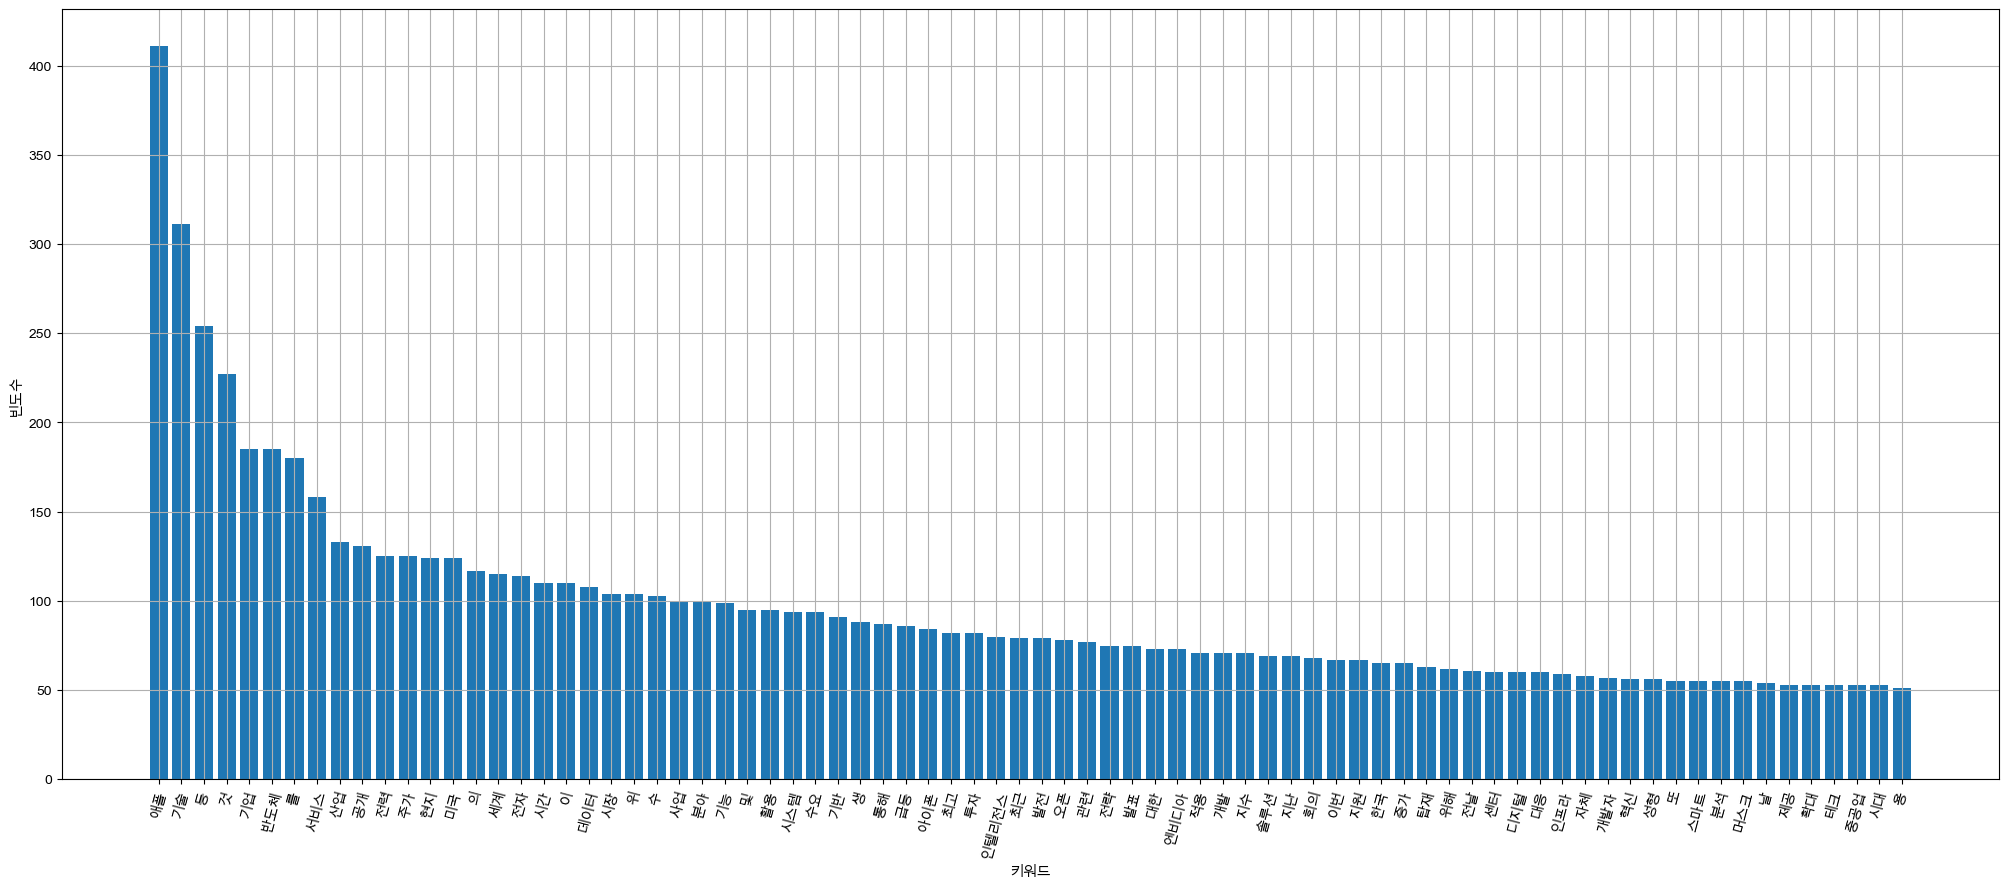

In [87]:
plt.figure(figsize=(25,10))
plt.xlabel('키워드')
plt.ylabel('빈도수')
plt.grid(True)

sorted_Keys = sorted(top_nouns, key=top_nouns.get, reverse=True)
sorted_Values = sorted(top_nouns.values(), reverse=True)

plt.bar(range(len(top_nouns)), sorted_Values, align='center')
plt.xticks(range(len(top_nouns)), list(sorted_Keys), rotation=75)

plt.show()

## 3.3 워드클라우드

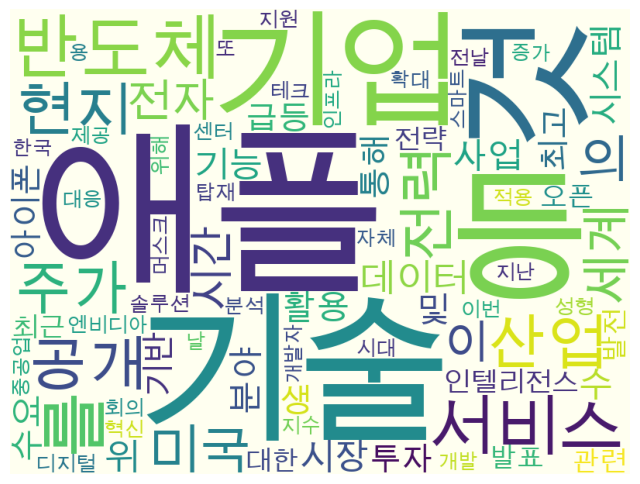

In [88]:
wc = WordCloud(font_path, background_color='ivory', width=800, height=600)
cloud=wc.generate_from_frequencies(top_nouns)

plt.figure(figsize=(8,8))
plt.imshow(cloud)
plt.axis('off')
plt.show()